In [19]:
!pip install tensorflow==1.14.0

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install keras==2.3.1

In [22]:
import tensorflow as tf
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet50
from keras.applications.resnet import decode_predictions
from keras.applications.resnet import preprocess_input
from keras.models import Model,Sequential
from keras.layers import Input,UpSampling2D,Flatten,BatchNormalization,Dense,Dropout,GlobalAveragePooling2D
from keras import optimizers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from PIL import Image

In [23]:
!nvidia-smi

Wed Oct 28 18:25:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
IMAGE_SIZE = [224, 224]#Give dataset path
train = '/content/drive/My Drive/Multiclass_cnn/Multi'
test = '/content/drive/My Drive/Multiclass_cnn/Multi_test'

In [25]:
# useful for getting number of classes
folders = glob('/content/drive/My Drive/Multiclass_cnn/Multi/*')
print(len(folders))
num_classes = 5
nb_epochs = 10

5


In [26]:
# Fixed for our dataset
NUM_CLASSES = 5

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

In [27]:
resnet=ResNet50(include_top=False, weights='imagenet',input_shape=IMAGE_SIZE + [3])

In [28]:
from keras.models import Model,Sequential
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [30]:
from keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [31]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/Multiclass_cnn/Multi',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')


validation_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/Multiclass_cnn/Multi_test',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 1039 images belonging to 5 classes.
Found 214 images belonging to 5 classes.


In [32]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


# Data Augmentation
test_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [33]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION
        
)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/10 [========>.....................] - ETA: 5:16 - loss: 1.7696 - accuracy: 0.2887

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/10 [==============>...............] - ETA: 4:19 - loss: 1.4029 - accuracy: 0.4601

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/10 [==============================] - 802s 80s/step - loss: 0.9216 - accuracy: 0.6613 - val_loss: 0.2374 - val_accuracy: 0.9070
Epoch 2/10
10/10 [==============================] - 521s 52s/step - loss: 0.1901 - accuracy: 0.9329 - val_loss: 0.1215 - val_accuracy: 0.9272
Epoch 3/10
10/10 [==============================] - 492s 49s/step - loss: 0.1246 - accuracy: 0.9499 - val_loss: 0.0619 - val_accuracy: 0.9527
Epoch 4/10
10/10 [==============================] - 542s 54s/step - loss: 0.0834 - accuracy: 0.9690 - val_loss: 0.1070 - val_accuracy: 0.9623
Epoch 5/10
10/10 [==============================] - 498s 50s/step - loss: 0.0612 - accuracy: 0.9863 - val_loss: 0.0695 - val_accuracy: 0.9744
Epoch 6/10
10/10 [==============================] - 505s 50s/step - loss: 0.0517 - accuracy: 0.9920 - val_loss: 0.0529 - val_accuracy: 0.9863
Epoch 7/10
10/10 [==============================] - 503s 50s/step - loss: 0.0456 - accuracy: 0.9920 - val_loss: 0.1642 - val_accuracy: 0.9636
Epoch 8/10
10/10 

In [34]:
model.save("/content/drive/My Drive/Multiclass_cnn/mymodelresnet1_5.h5")
print("Saved model to disk")

Saved model to disk


In [35]:
import numpy as np

from keras.preprocessing import image

In [36]:
from tensorflow.python.keras.models import load_model

In [100]:
test_image = image.load_img('/content/drive/My Drive/Multiclass_cnn/Multi/cat/cat102.jpg', target_size = (224, 224))

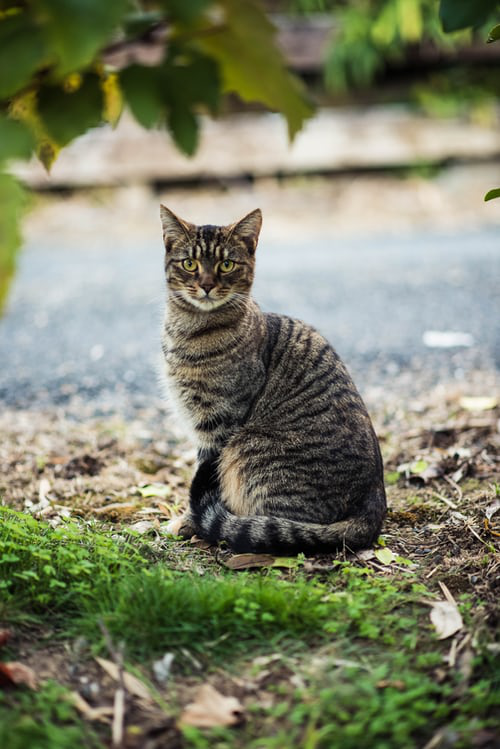

In [101]:
#show image
from IPython.display import display # to display images

img = Image.open('/content/drive/My Drive/Multiclass_cnn/Multi/cat/cat102.jpg')
display(img)

In [102]:
test_image = image.img_to_array(test_image)

In [103]:
test_image = np.expand_dims(test_image, axis = 0)

In [104]:
model = load_model('/content/drive/My Drive/Multiclass_cnn/mymodelresnet1_5.h5')

In [105]:
result = model.predict(test_image)

In [106]:
result = result[0]

In [107]:
classes = ['cat','cow', 'horse', 'nikita','ram']

label_name = {classes[i]: result[i] for i in range(len(result))}
label_name

{'cat': 0.9985964,
 'cow': 1.2774073e-05,
 'horse': 0.00017380338,
 'nikita': 0.00033599578,
 'ram': 0.0008811056}

In [108]:
output = max(label_name, key=label_name.get)
print(output)

cat
